# Input

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import re
import os
from pathlib import Path
import sys

In [ ]:
# Specify required input

# Add SynFlow to path in order to import modules
repo_root = "/home/volt/bach/SynFlow"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Regex corpus_pattern to extract relevant information from CoNLL-U files
corpus_pattern = re.compile(
    r'([^\t]+)\t'      # word form
    r'([^\t]+)\t'      # lemma
    r'([^\t])[^\t]*\t' # POS (UPOS or XPOS)
    r'([^\t]+)\t'      # ID
    r'([^\t]+)\t'      # HEAD
    r'([^\t]+)'        # DEPREL
)

# Specify target lemma and part of speech
target_lemma = 'air'
target_pos = 'N'

# Specify corpus and output folders
period = '1750-1819'
corpus_folder = f'/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades'
output_folder = Path(f'/home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/')

In [5]:
# Dont change below this line
output_folder_lemma = output_folder / 'output' / f'{target_lemma}-{target_pos}-{period}'
output_explorer = f'{output_folder_lemma}/Explorer'
output_embedding = f'{output_folder_lemma}/Embedding'
input_SCD = output_folder / 'input' / 'SCD' /f'{target_lemma}-{target_pos}-{period}'

os.makedirs(output_explorer, exist_ok=True)
os.makedirs(output_embedding, exist_ok=True)
os.makedirs(input_SCD, exist_ok=True)

# Explore the vocab freq

In [49]:
from SynFlow.Explorer.vocab_freq import gen_lemma_freq, analyze_corpus_vocab

In [50]:
gen_lemma_freq(corpus_folder, 
               '/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades_vocab', # Output folder for vocab files
               file_ext='.txt', mode='lemma_pos_init') # modes: 'lemma_pos', 'lemma_pos_init', or 'lemma_deprel'

In [51]:
analyze_corpus_vocab('/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades_vocab')

Starting analysis of: /home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades_vocab



{'1750_lemma_pos_init_freq.txt': {'tokens': 108868,
  'types': 6655,
  'words': 6054},
 '1755_lemma_pos_init_freq.txt': {'tokens': 154782,
  'types': 7688,
  'words': 6947},
 '1760_lemma_pos_init_freq.txt': {'tokens': 49896,
  'types': 4402,
  'words': 3950},
 '1765_lemma_pos_init_freq.txt': {'tokens': 132339,
  'types': 6781,
  'words': 6130},
 '1770_lemma_pos_init_freq.txt': {'tokens': 282601,
  'types': 11132,
  'words': 9970},
 '1775_lemma_pos_init_freq.txt': {'tokens': 332576,
  'types': 11940,
  'words': 10800},
 '1780_lemma_pos_init_freq.txt': {'tokens': 286459,
  'types': 10712,
  'words': 9665},
 '1785_lemma_pos_init_freq.txt': {'tokens': 265283,
  'types': 8736,
  'words': 7810},
 '1790_lemma_pos_init_freq.txt': {'tokens': 232193,
  'types': 17749,
  'words': 16414},
 '1795_lemma_pos_init_freq.txt': {'tokens': 252694,
  'types': 13675,
  'words': 12493},
 '1800_lemma_pos_init_freq.txt': {'tokens': 602305,
  'types': 19308,
  'words': 17619},
 '1805_lemma_pos_init_freq.txt': {

# Explore the distribution of different syntactic slots from the corpus

## Slot-path Explorer

[1750] Collected 705 context links, 34 distinct arguments.


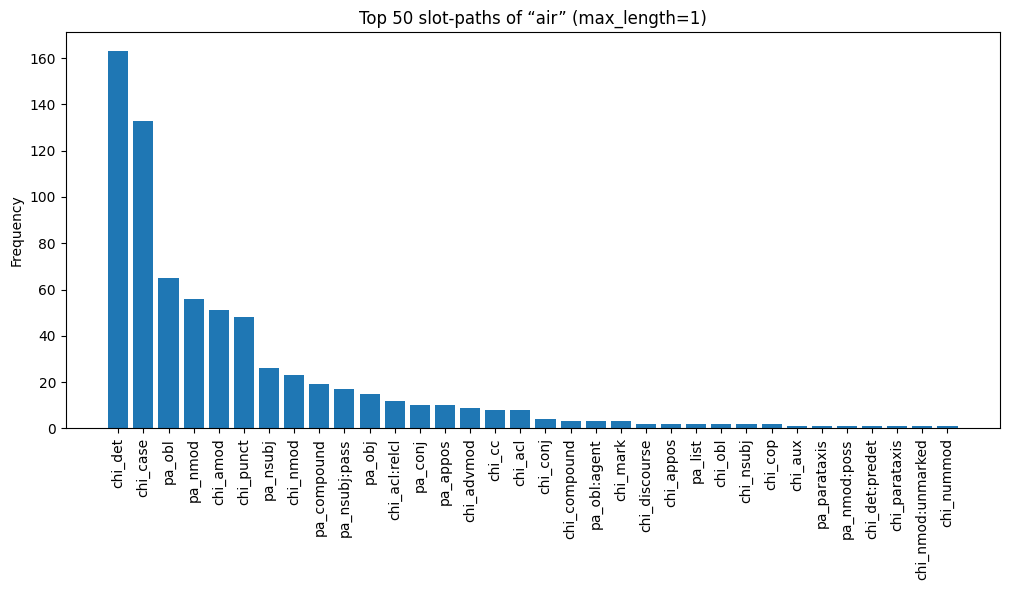

[1755] Collected 820 context links, 29 distinct arguments.


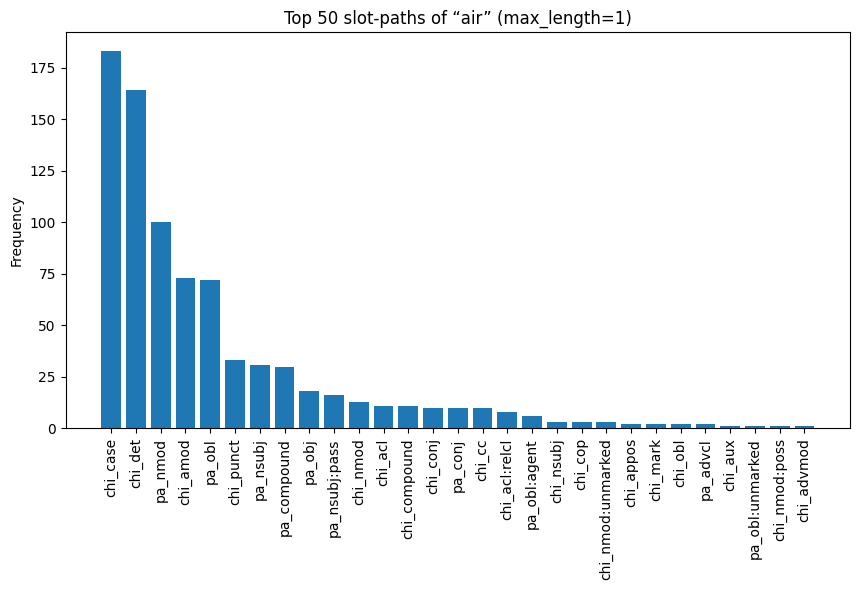

[1760] Collected 374 context links, 21 distinct arguments.


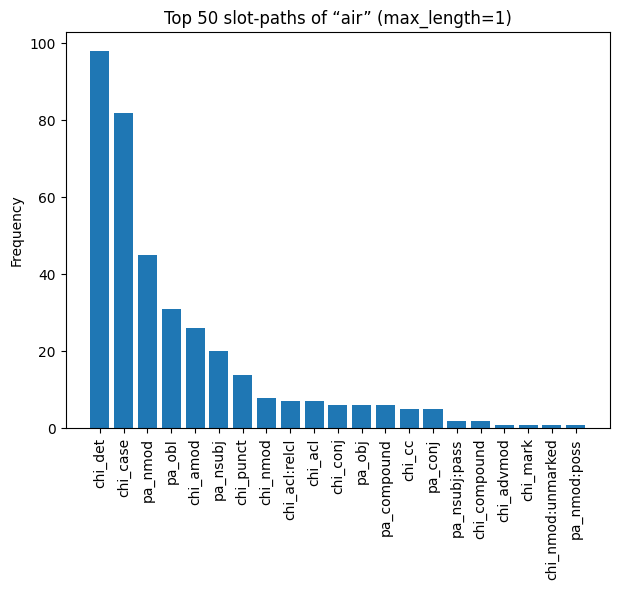

[1765] Collected 2924 context links, 39 distinct arguments.


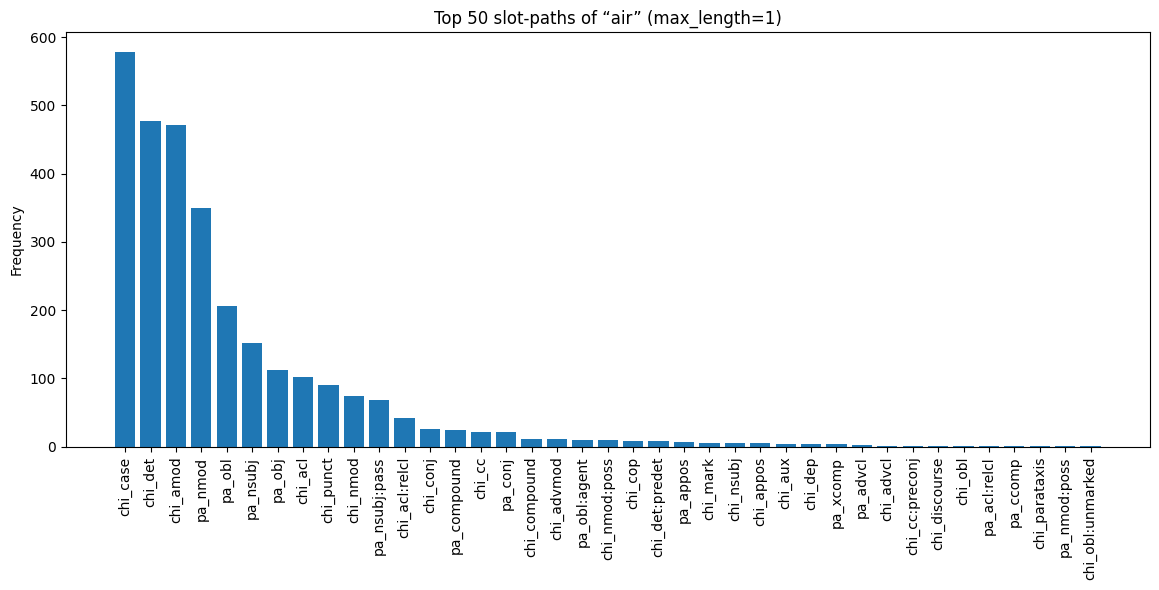

[1770] Collected 4551 context links, 45 distinct arguments.


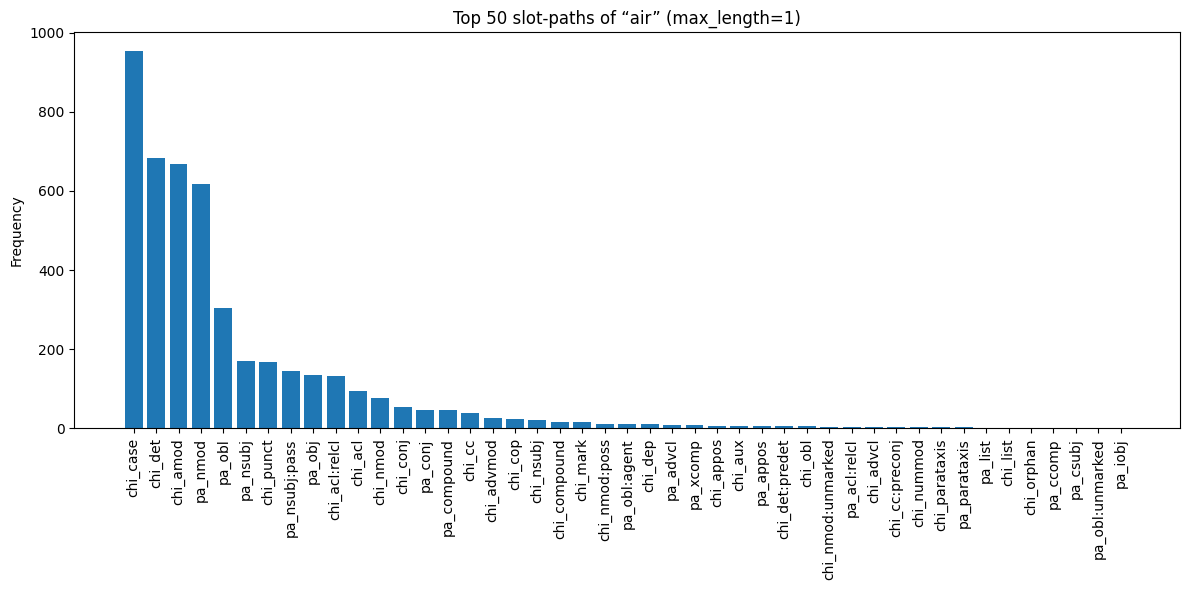

[1775] Collected 5264 context links, 44 distinct arguments.


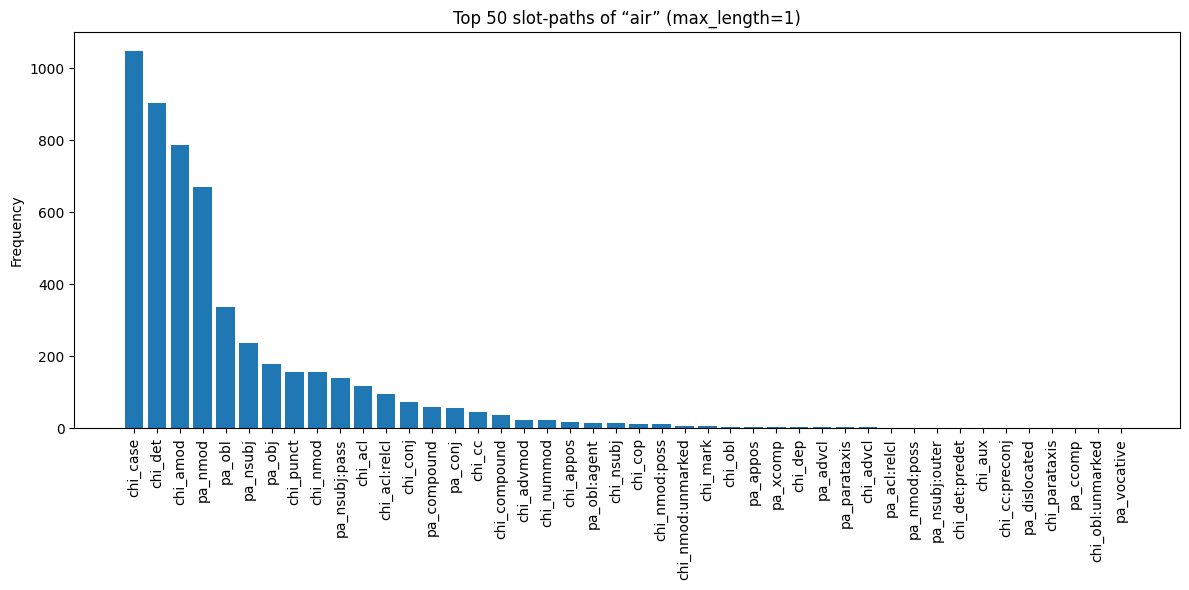

[1780] Collected 9045 context links, 50 distinct arguments.


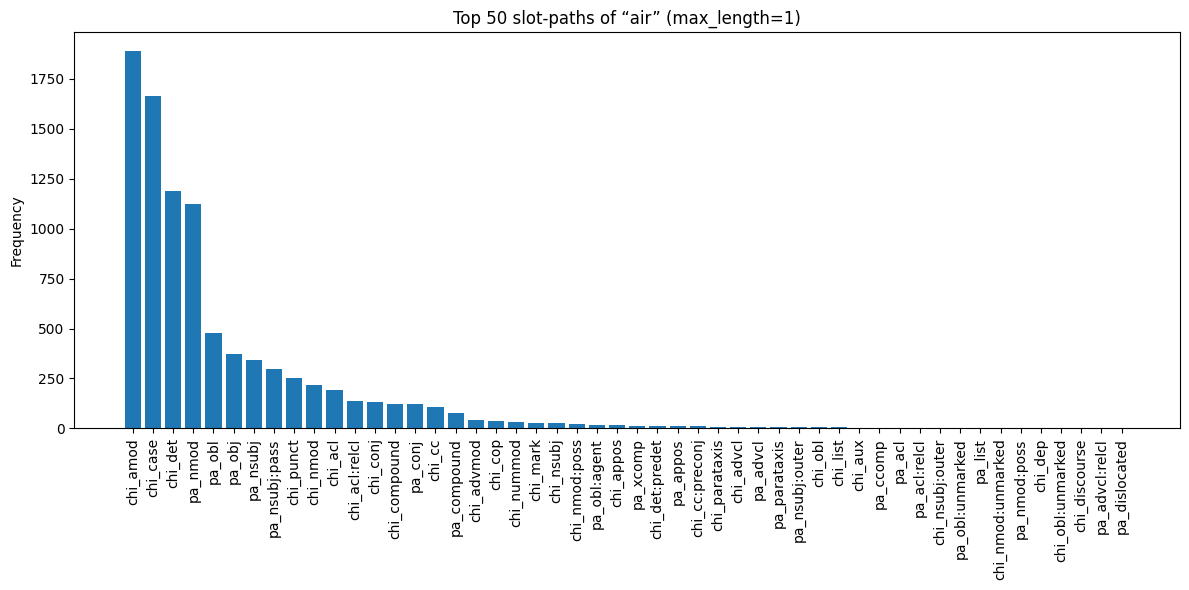

[1785] Collected 7450 context links, 44 distinct arguments.


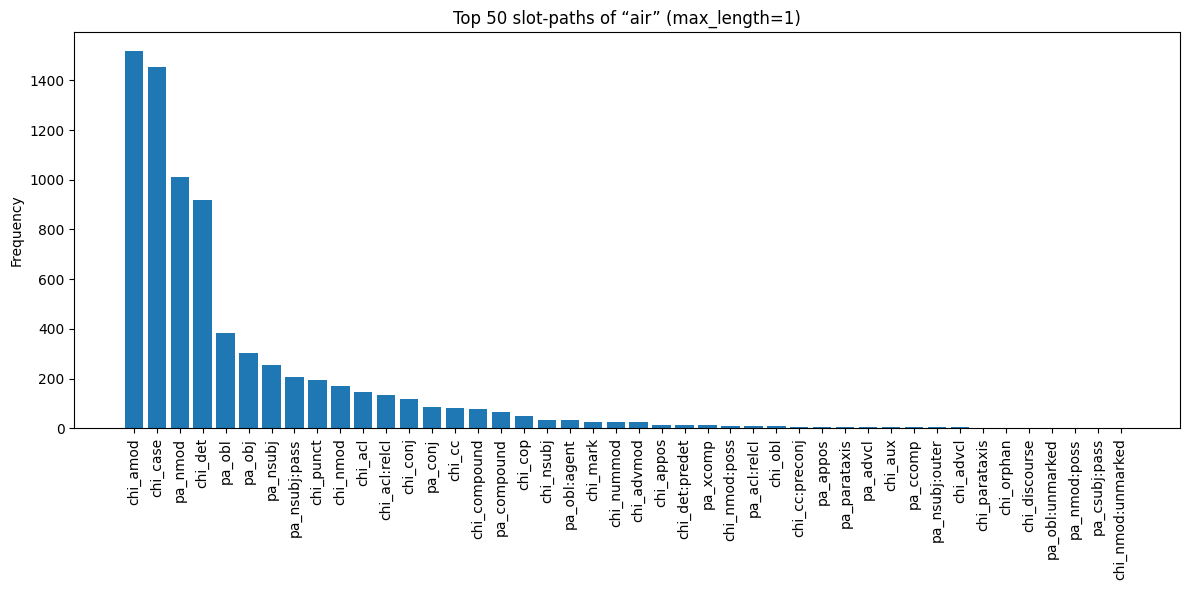

[1790] Collected 4742 context links, 42 distinct arguments.


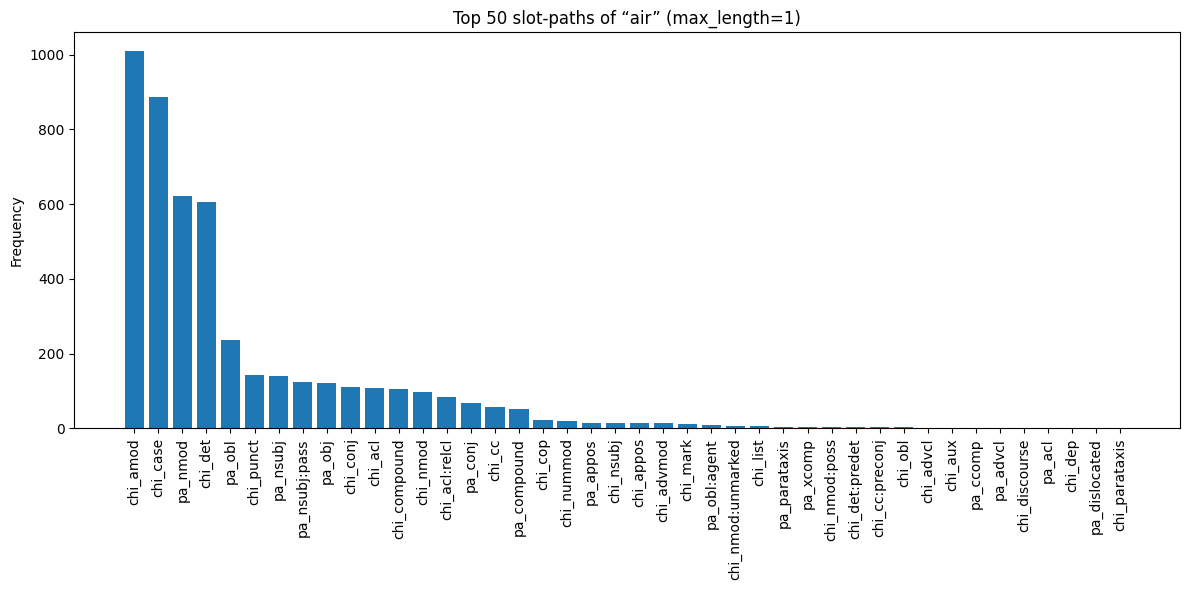

[1795] Collected 882 context links, 34 distinct arguments.


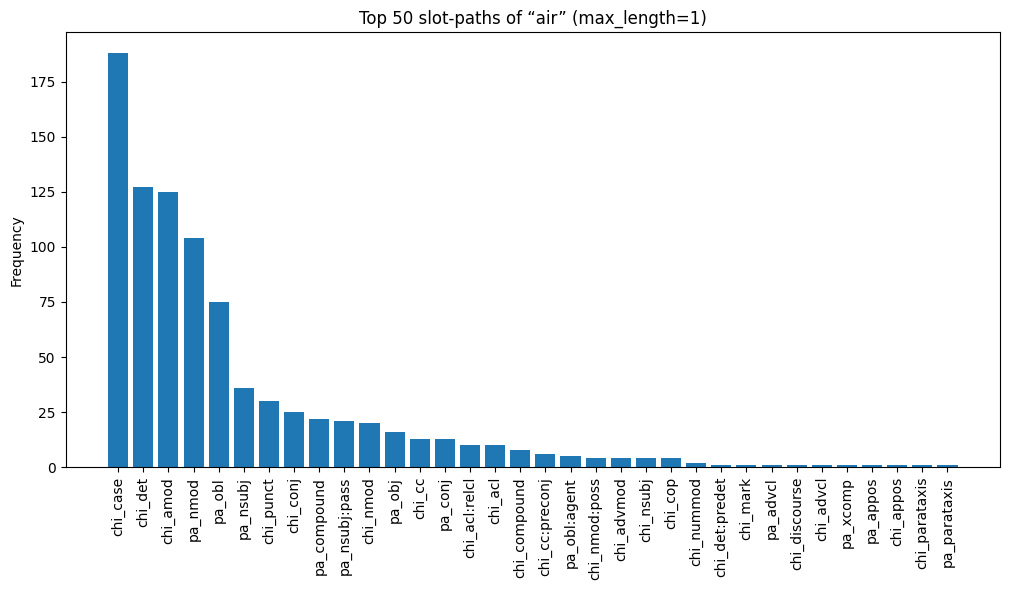

[1800] Collected 1784 context links, 39 distinct arguments.


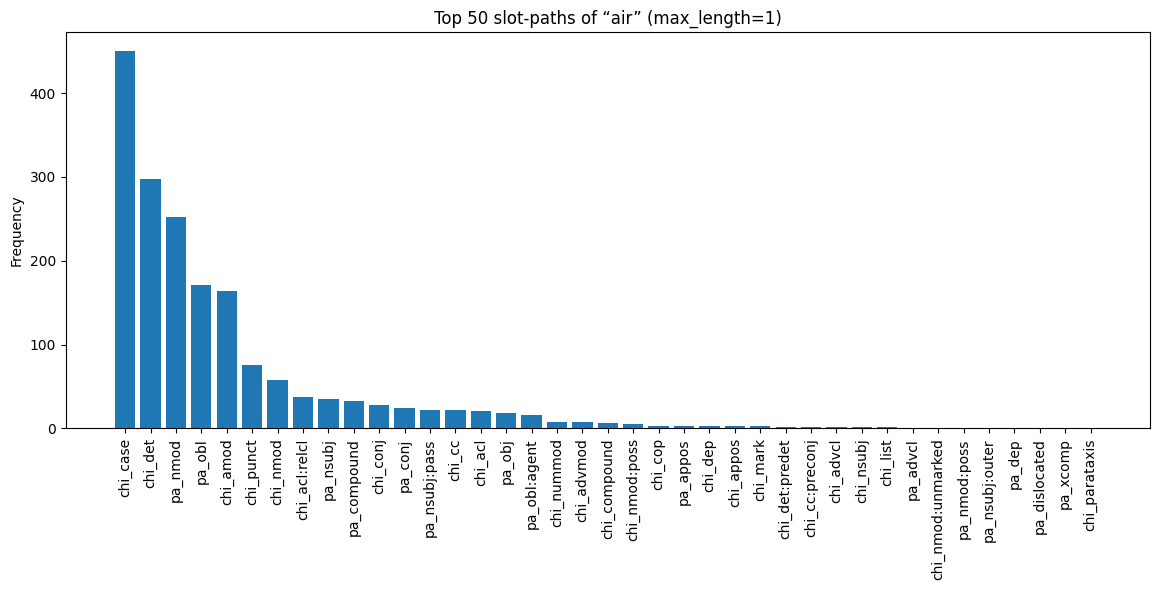

[1805] Collected 977 context links, 30 distinct arguments.


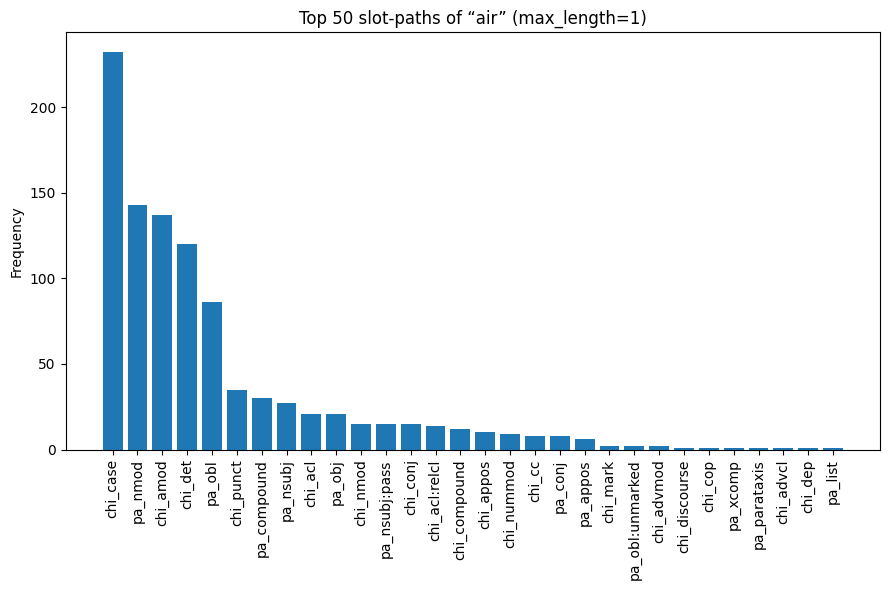

[1810] Collected 786 context links, 32 distinct arguments.


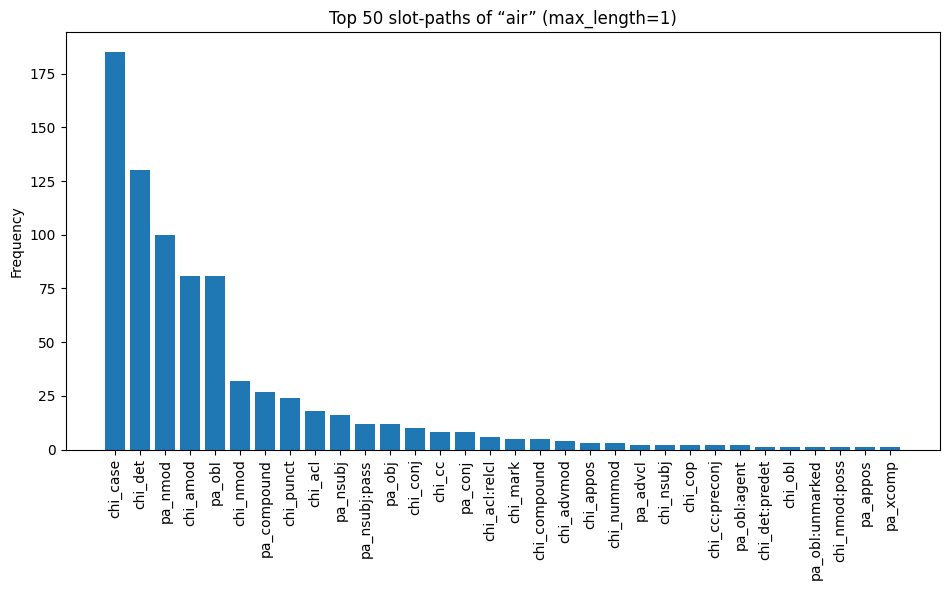

[1815] Collected 1121 context links, 30 distinct arguments.


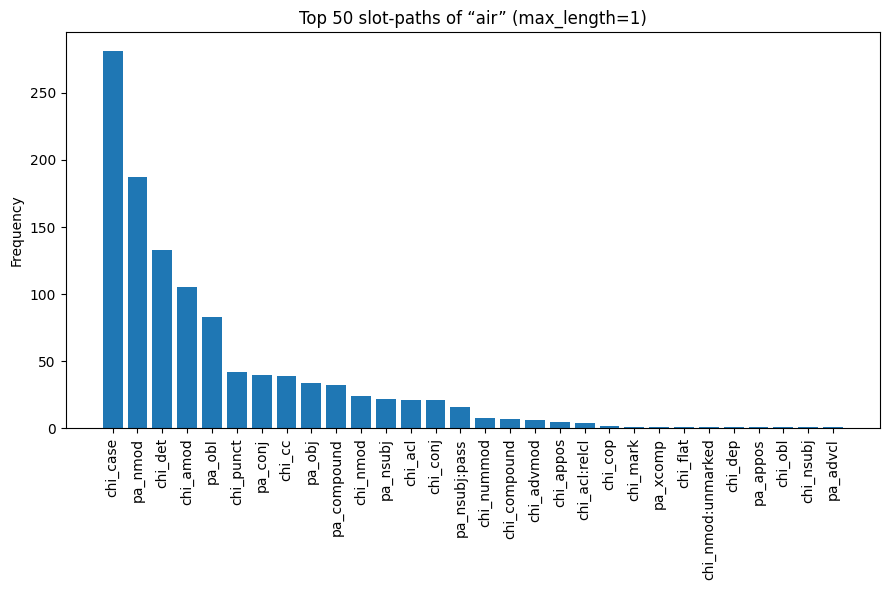

Saved slot-path frequencies to: /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spaths.json


In [52]:
from SynFlow.Explorer import spath_explorer
dist = spath_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=50,
    pattern=corpus_pattern,
    output_folder=output_explorer
)

## Unique Slot-path Combination Explorer

[1750] Total instances: 226, distinct patterns: 72


/home/volt/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


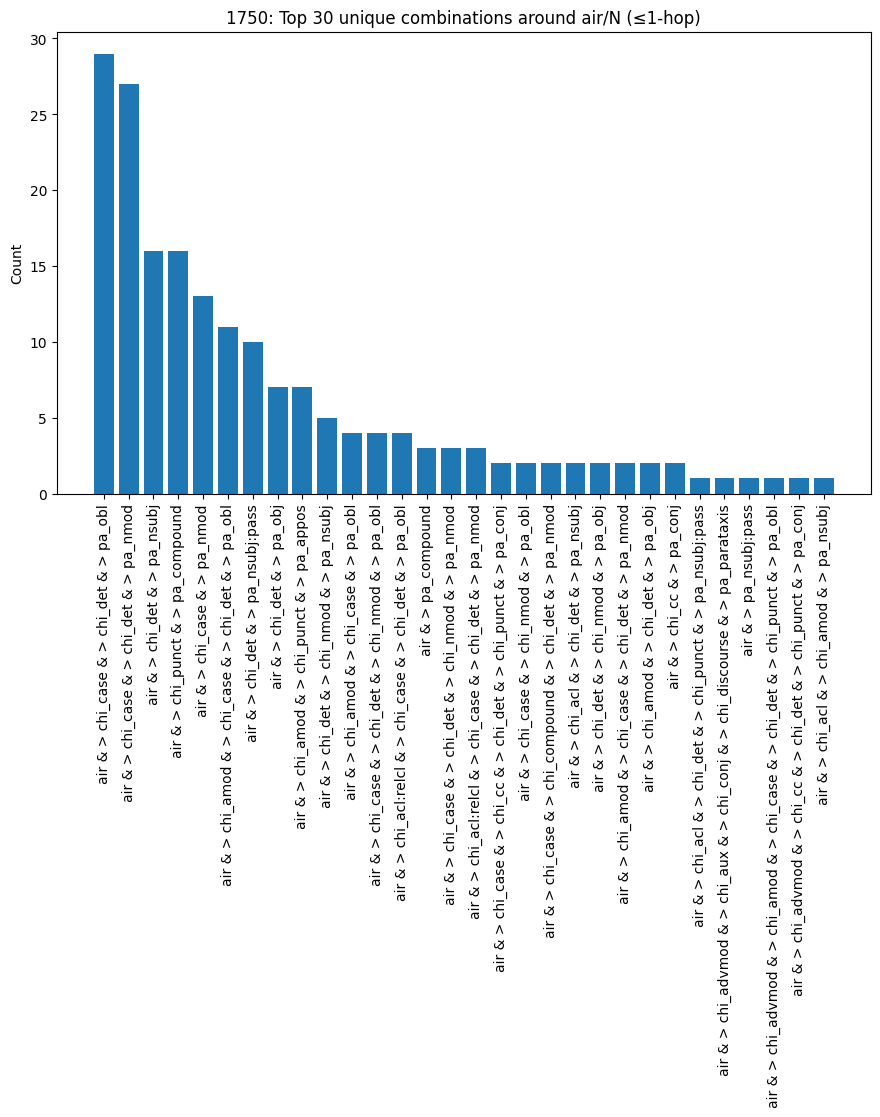

[1755] Total instances: 287, distinct patterns: 73


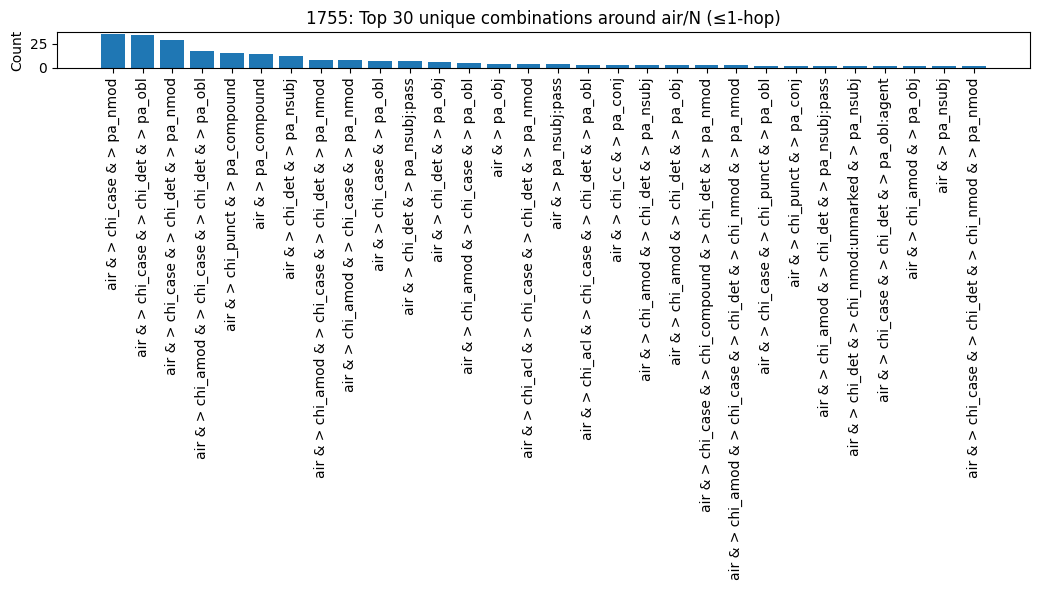

[1760] Total instances: 117, distinct patterns: 44


/home/volt/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


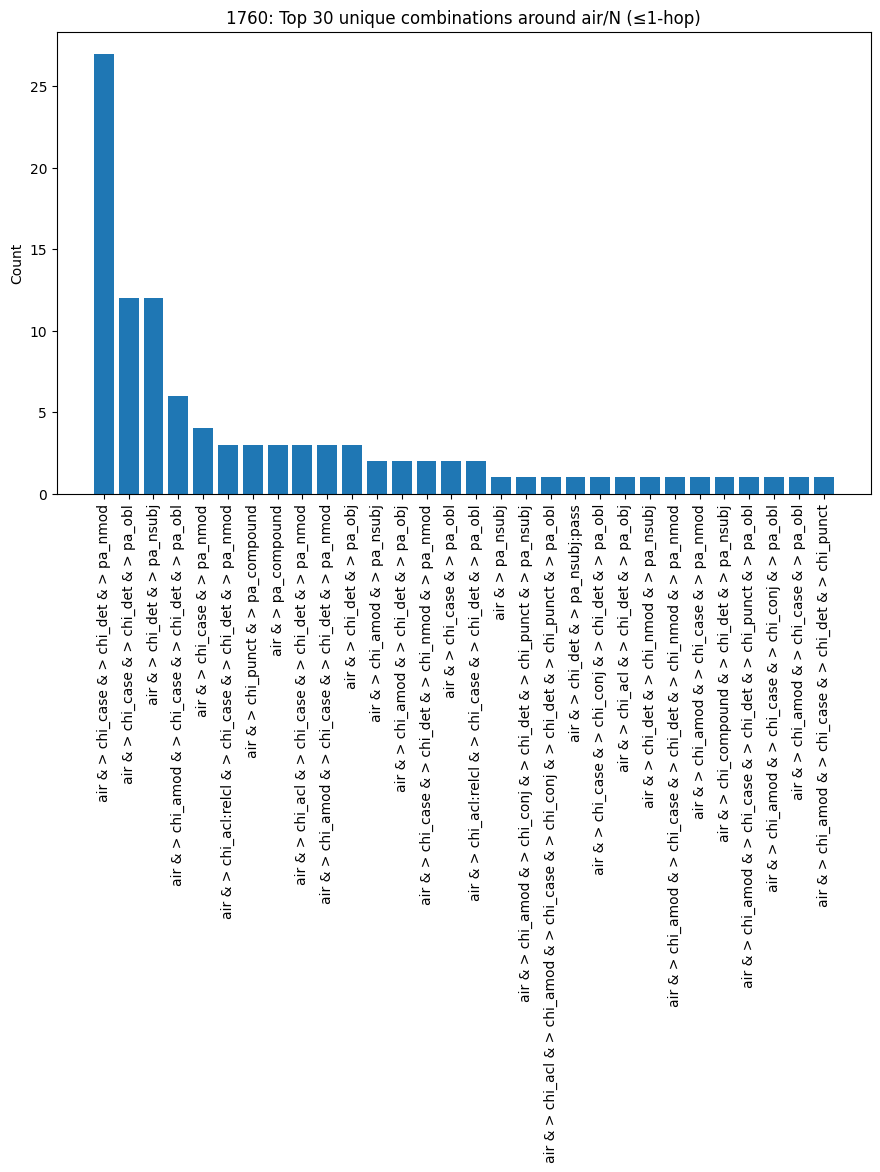

[1765] Total instances: 967, distinct patterns: 177


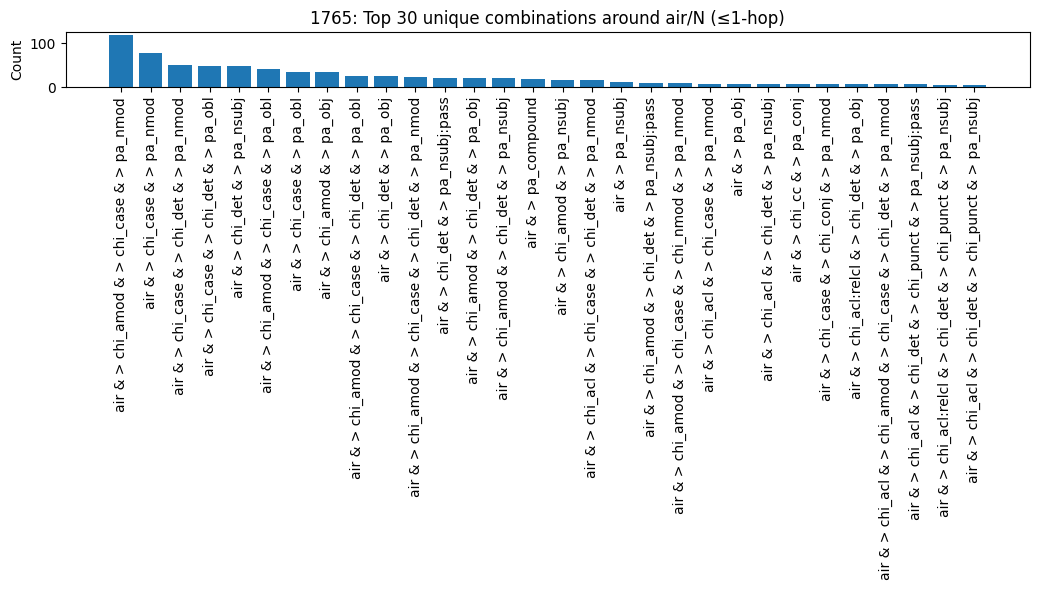

[1770] Total instances: 1516, distinct patterns: 247


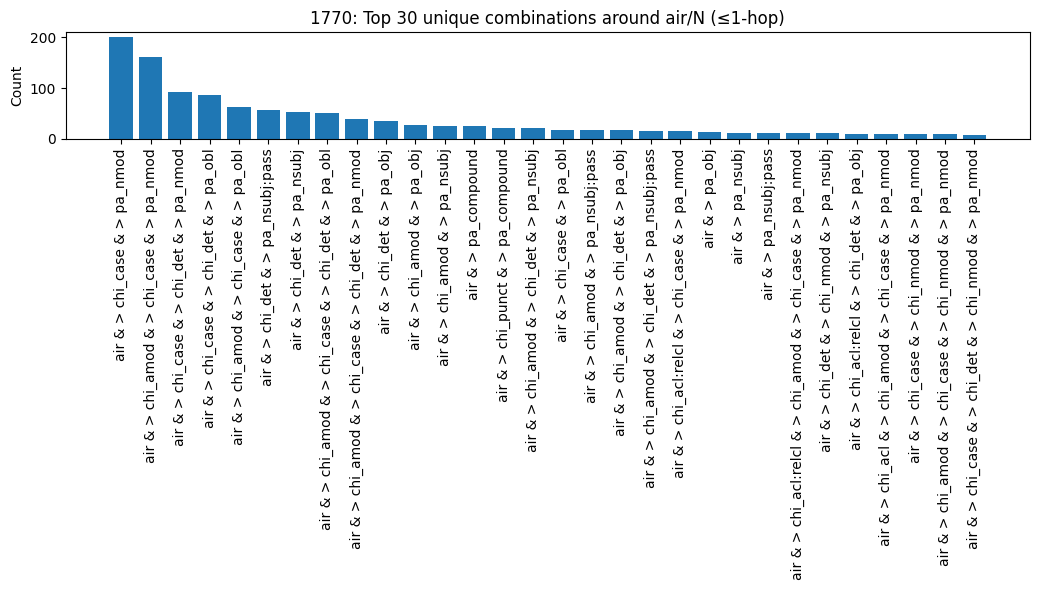

[1775] Total instances: 1721, distinct patterns: 271


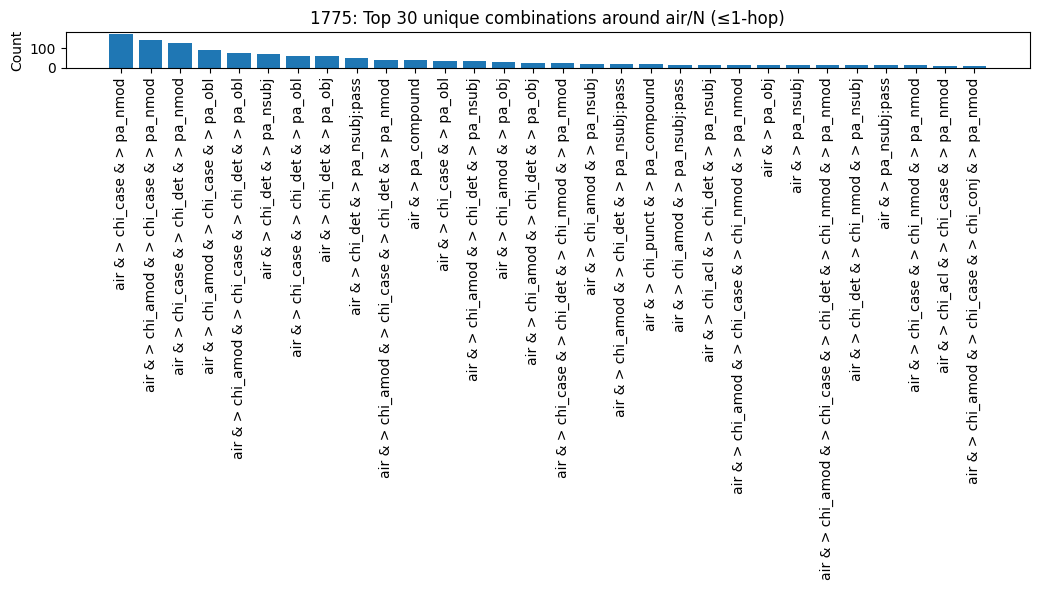

[1780] Total instances: 2900, distinct patterns: 395


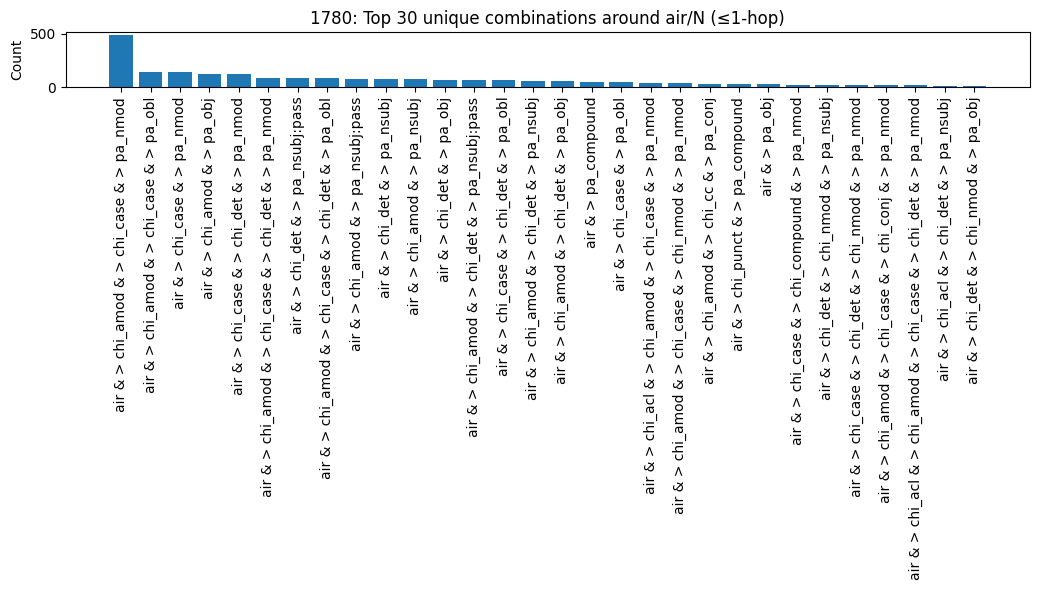

[1785] Total instances: 2405, distinct patterns: 341


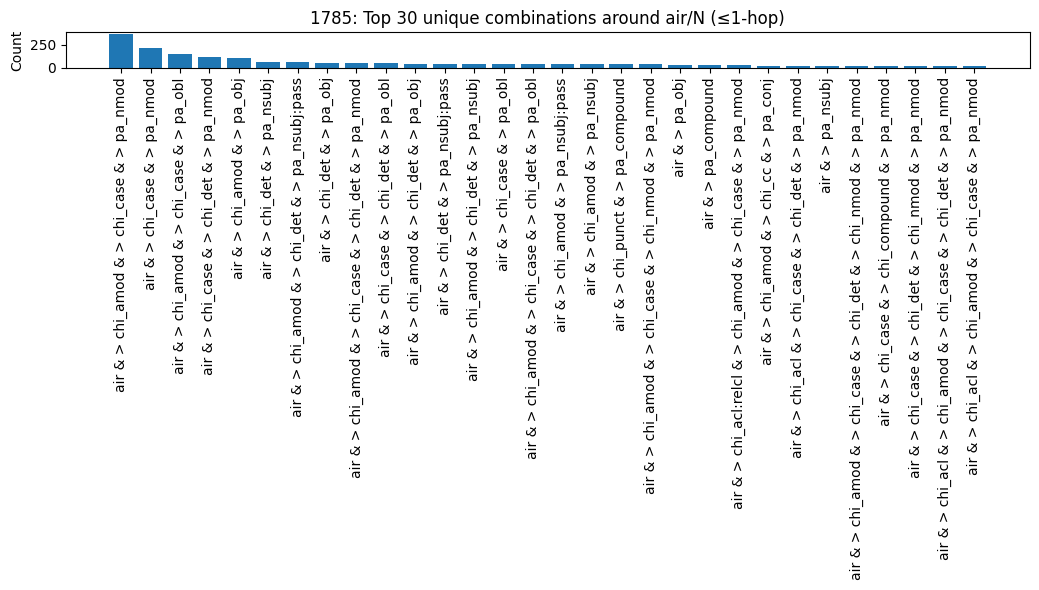

[1790] Total instances: 1414, distinct patterns: 292


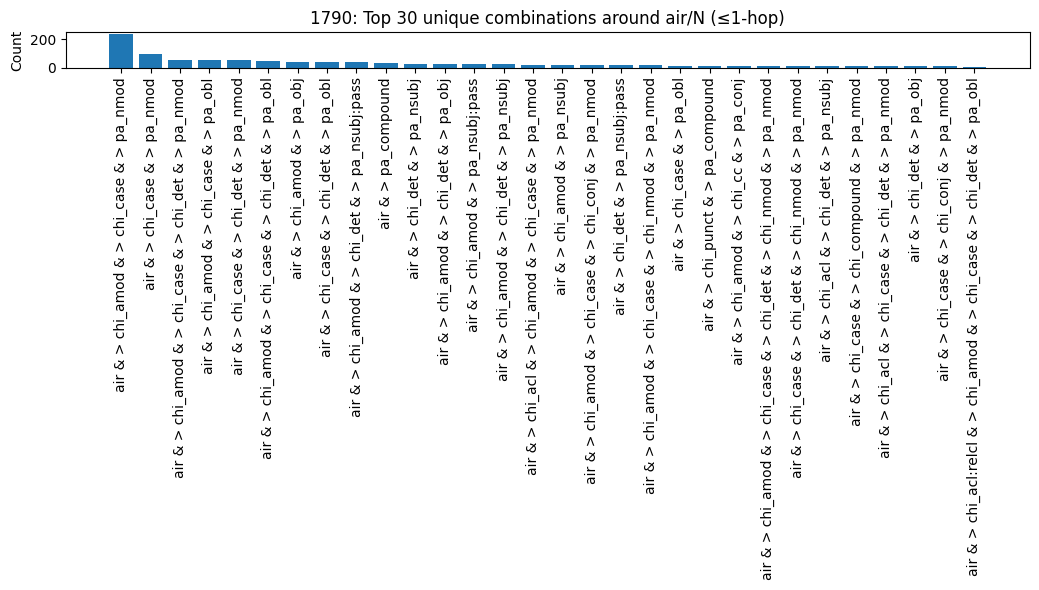

[1795] Total instances: 298, distinct patterns: 95


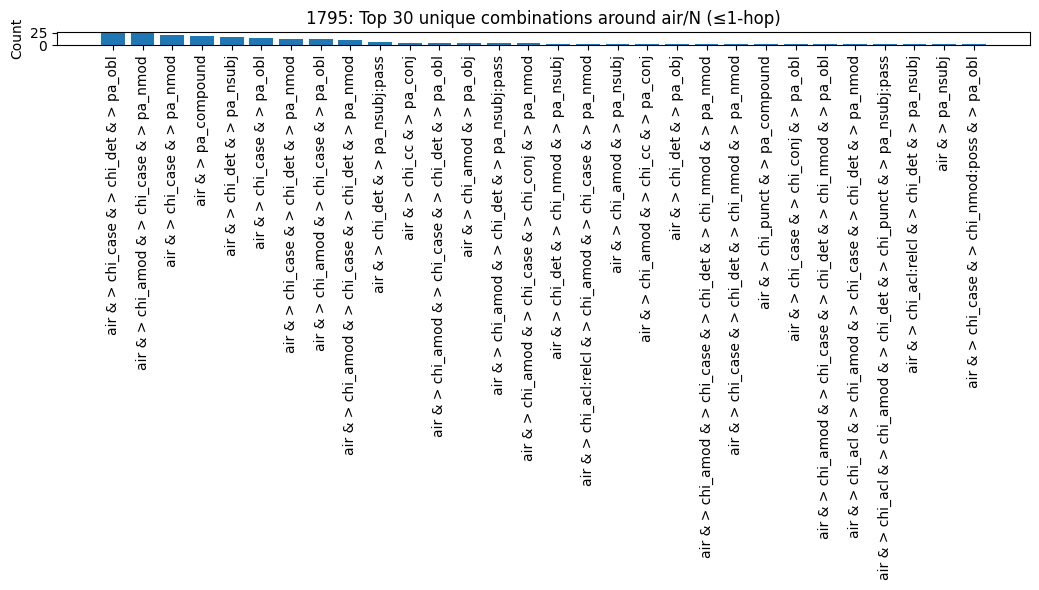

[1800] Total instances: 581, distinct patterns: 133


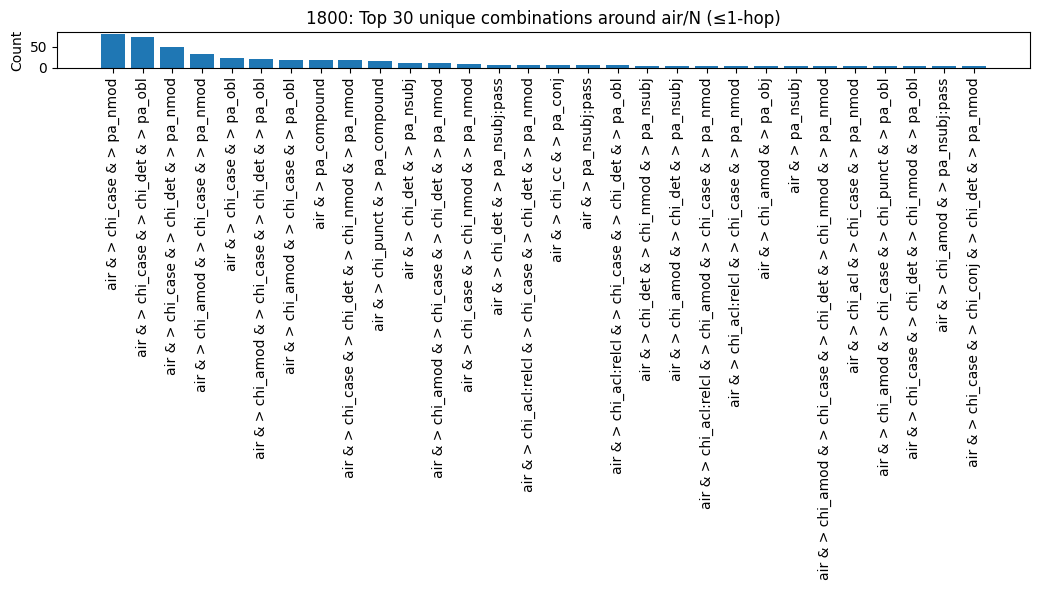

[1805] Total instances: 344, distinct patterns: 94


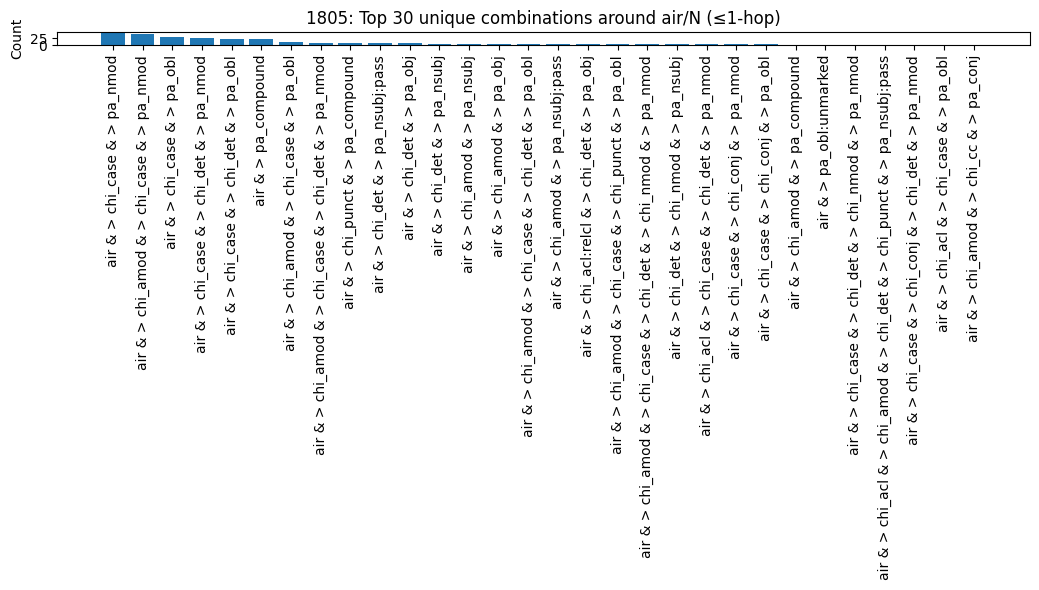

[1810] Total instances: 265, distinct patterns: 77


/home/volt/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


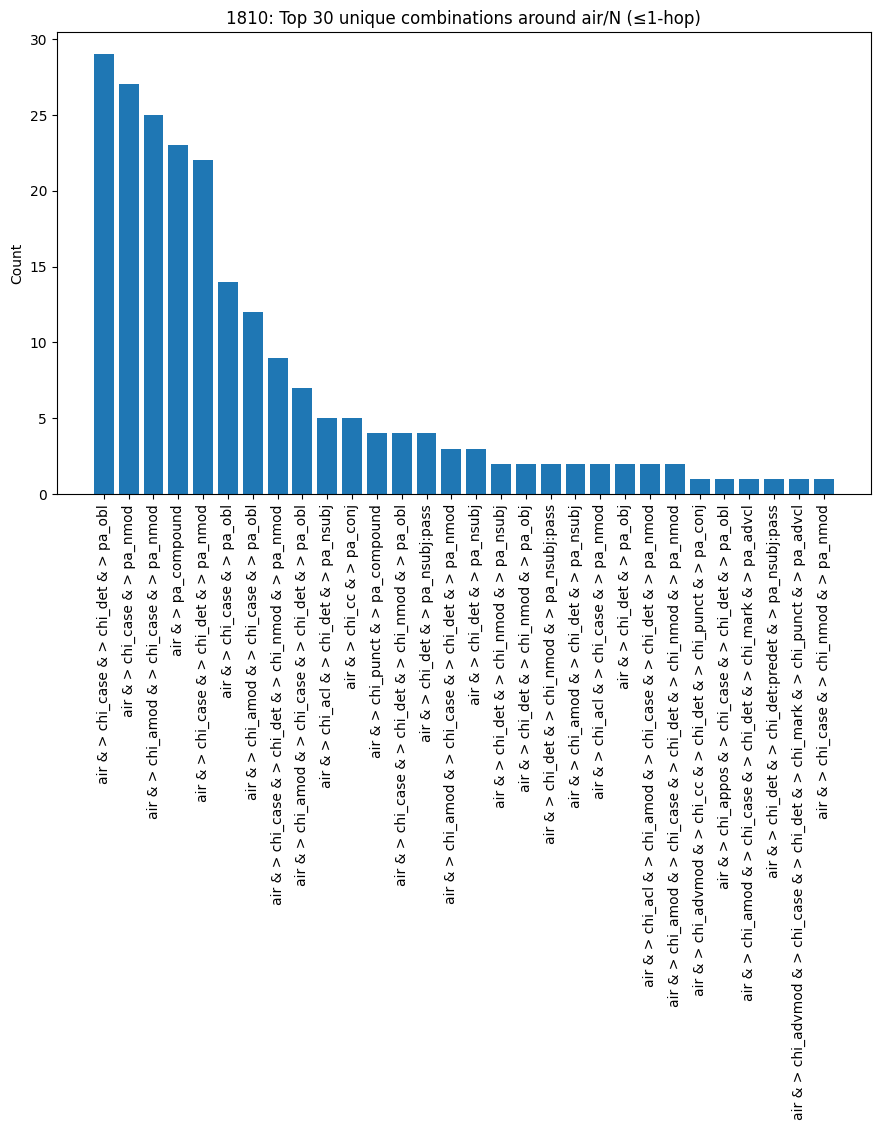

[1815] Total instances: 418, distinct patterns: 92


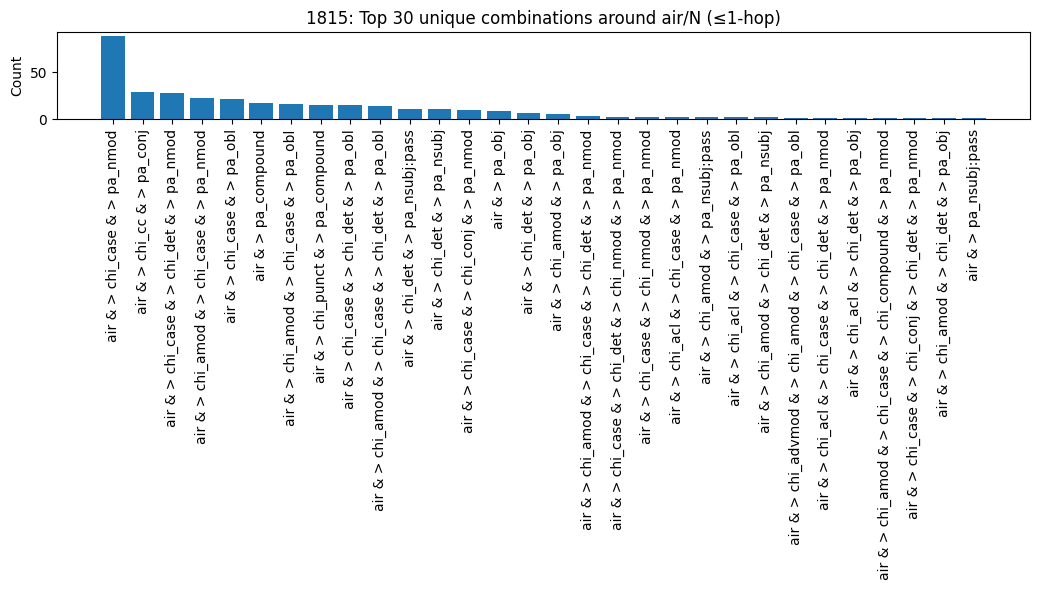

CSV saved to /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv


In [53]:
# 1 unique full-pattern string for 1 token
from SynFlow.Explorer import spath_comb_explorer

ctr = spath_comb_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=30,
    output_folder=output_explorer,
    pattern=corpus_pattern
)

## Rel Explorer

In [54]:
from SynFlow.Explorer import rel_explorer

rel_explorer_results = rel_explorer(
    corpus_folder=corpus_folder,
    pattern=corpus_pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="pa_nsubj",
)

In [55]:
for fname, sent, sfillers, path in rel_explorer_results[:10000]:
    # ctx_list là một list các "lemma/pos", nối bằng ' > ' để in cho dễ nhìn
    sfillers = " > ".join(sfillers)
    print(f"{fname:15} | {path:10} | {sfillers:15} | {sent}")

# Save to csv
import csv
out_path = f'{output_explorer}/rel_explorer.tsv'
with open(out_path, "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f, delimiter='\t')
    w.writerow(["file", "path", "sfillers", "sentence"])
    for fname, sent, sfillers, path in rel_explorer_results:
        sfillers = " > ".join(sfillers)
        w.writerow([fname, path, sfillers, sent])

Royal_Society_Corpus_open_v6.0_text_105166_1753.txt | pa_nsubj   | moist/A         | ON the 7th of this month I was at the palace of St. German 's near Paris , where I had the satisfaction of feeing Dr. le Monnier 's experiment relating to the electricity of the air ; of which an account was sent me by Abbe Mazeas , and was read before our honourable Society in December last ; and I observed , that though the wind was westerly , and the air moist , yet the suspended wire , at different times , attracted very light bodies , at very small distances ; the mean of which distances seemed to be about 1 / 10 of an inch .
Royal_Society_Corpus_open_v6.0_text_105167_1753.txt | pa_nsubj   | render/V        | Experiment 7 . Let the tin tube , with a pair of balls at one end , be placed three feet at least from any part of the room , and the air rendered very dry by means of a fire : electrify the apparatus to a considerable degree ; then touch the tin tube with a finger , or any other conductor , 

## Full Rel Explorer

In [56]:
from SynFlow.Explorer import full_rel_explorer

full_rel_explorer_results = full_rel_explorer(
    corpus_folder=corpus_folder,
    pattern=corpus_pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="chi_case & chi_det & pa_obl",
    # rel="chi_aux & chi_nsubj & chi_obj & chi_punct",
    # rel="chi_discourse > chi_punct & chi_punct",
    mode = 'close', # 'open', 'close', 'closeh'
)

In [57]:
# inspect a few
sent_num = 0
for fname, sent, paths_details_list in full_rel_explorer_results[:10]:
    sent_num += 1
    # paths_details_list is a list of (sfillers, path) tuples
    for sfillers, path in paths_details_list:
        # sfillers is a list of "lemma/pos", join using ' > ' to print
        sfillers = " > ".join(sfillers)
        print(f"{sent_num} | {fname:15} | {path:10} | {sfillers:15} | {sent}")

# Save to csv
import csv
out_path = f'{output_explorer}/full_rel_explorer.tsv'
with open(out_path, "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f, delimiter='\t')
    w.writerow(["sent_num", "file", "path", "ctx_nodes", "sentence"])
    sent_num = 0
    for fname, sent, paths_details_list in full_rel_explorer_results:
        sent_num += 1
        for sfillers, path in paths_details_list:
            sfillers = " > ".join(sfillers)
            w.writerow([sent_num, fname, path, sfillers, sent])

1 | Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | chi_case   | in/A            | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
1 | Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | chi_det    | the/D           | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
1 | Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | pa_obl     | hang/V          | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
2 | Royal_Society_Corpus_open_v6.0_text_105166_1753.txt | chi_case   | with/A          | He was perfectly satisfied that the experiments were fairly made , and that the explosion was much greater when the apparatus communicated with the e

## Trimming

In [58]:
import pandas as pd
# Load the CSV file
df = pd.read_csv('/home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv', sep='&')
df.head(10)

,Subfolder,Frequency,Target,Slot1,Slot2,Slot3,Slot4,Slot5,Slot6,Slot7,Slot8,Slot9,Slot10
0,1750,29,air,> chi_case,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,27,air,> chi_case,> chi_det,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,16,air,> chi_det,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,16,air,> chi_punct,> pa_compound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,13,air,> chi_case,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1750,11,air,> chi_amod,> chi_case,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN
6,1750,10,air,> chi_det,> pa_nsubj:pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1750,7,air,> chi_det,> pa_obj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1750,7,air,> chi_amod,> chi_punct,> pa_appos,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1750,5,air,> chi_det,> chi_nmod,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
from SynFlow.Explorer import trim_and_merge

# Trim and merge relations
spath_df = '/home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv'
trimmed_rels = ['chi_case']
trim_and_merge(spath_df=spath_df, trimmed_rels=trimmed_rels)

Saved merged file to /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops_trimmed.csv


,Subfolder,Frequency,Target,Slot_1,Slot_2,Slot_3,Slot_4,Slot_5,Slot_6,Slot_7,Slot_8,Slot_9
0,1750,29,air,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,27,air,> chi_det,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,16,air,> chi_det,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,16,air,> chi_punct,> pa_compound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,13,air,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2337,1815,1,air,> chi_nummod,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,1815,1,air,> chi_punct,> pa_conj,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339,1815,1,air,> chi_punct,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2340,1815,1,air,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Specialisations Grouping

In [60]:
from SynFlow.Explorer.trimming import spe_group

spath_df = '/home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv'
tree = spe_group(spath_df, output_folder=output_explorer, target_lemma=target_lemma)

Saved to /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Explorer/air_spath_comb_grouped.json


# Get Slot-filler df

In [61]:
from SynFlow.Explorer import build_sfiller_df

sfiller_df = build_sfiller_df(
    corpus_folder=corpus_folder,
    template='[pa_conj]', # Example: '[chi_nsubj][chi_obj][chi_obl > chi_case]'
    target_lemma=target_lemma,
    target_pos=target_pos,
    pattern=corpus_pattern,
    # freq_path='/home/volt/bach/pilot_data/RSC/lemma_pos_init_freq.txt', # Be sure that the freq_path matches that of the filter format
    # freq_min=1,
    # freq_max=100_000_000,
    filtered_pos=[],
    filler_format='lemma/pos', # lemma/deprel or 'lemma/pos'
    output_folder= output_embedding
)

Wrote slot‐fillers to /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv (516 rows), dropped 12943 tokens.


In [62]:
# Sampling from the general slots DataFrame
from SynFlow.Explorer import sample_sfiller_df
n = 5
sfiller_sample_df = sample_sfiller_df(
    input_csv=f"{output_embedding}/{target_lemma}_samples_sfillerdf_all.csv",
    output_csv=f"{output_embedding}/{target_lemma}_samples_sfillerdf_{n}.csv",
    n=n,
    seed=42,
    mode= 'NA'
)

Sampled 70 rows from /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv → /home/volt/bach/SynFlow/case_studies/RSC_air_water_acid/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_5.csv
